Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать одну или несколько метрик, которая отвечает за качество сервиса и статистически сравнить эти метрики в двух группах.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

В данных вы найдете логи заказов пользователей:

`ab_users_data` – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
`ab_orders` – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
`ab_products` – подробная информация о продуктах, их название и стоимость

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sc
import numpy as np
import statsmodels.api as sm

### 1. Для начала загрузим данные и посмотрим на них и проведем EDA.

In [ ]:
orders = pd.read_csv('ab_orders.csv')
products = pd.read_csv('ab_products.csv')
users_data = pd.read_csv('ab_users_data.csv')

<span style="color:green">**1. Проанализируем таблицу `orders`**</span>

In [ ]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [ ]:
print(f'Количество пропусков по столбцам равно: \n{orders.isna().sum()}\n'
      f'Количество дублей в заказах равно:\norder_id = {orders.order_id.duplicated().sum()}\n'
      f'Типы данных в таблице представлены в виде:\n{orders.dtypes}')

Количество пропусков по столбцам равно: 
order_id         0
creation_time    0
product_ids      0
dtype: int64
Количество дублей в заказах равно:
order_id = 0
Типы данных в таблице представлены в виде:
order_id          int64
creation_time    object
product_ids      object
dtype: object


<span style="color:green">**2. Проанализируем таблицу `products`**</span>

In [ ]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [ ]:
products.name.unique()

array(['сахар', 'чай зеленый в пакетиках', 'вода негазированная',
       'леденцы', 'кофе 3 в 1', 'сухарики', 'кофе зерновой', 'сушки',
       'чай черный листовой', 'семечки', 'масло льняное', 'виноград',
       'икра', 'майонез', 'масло оливковое', 'арбуз', 'морс брусничный',
       'кетчуп', 'рыба соленая', 'батон', 'кофе молотый',
       'сок мультифрукт', 'йогурт', 'сок апельсиновый',
       'кофе растворимый', 'чипсы', 'чай травяной листовой', 'сливки',
       'морс черничный', 'энергетический напиток', 'гречка', 'овсянка',
       'шоколад черный', 'макароны', 'лимонад', 'чайный гриб', 'баранина',
       'апельсины', 'бублики', 'хлеб', 'вода газированная', 'горох',
       'кофе без кофеина', 'мармелад', 'чай зеленый листовой', 'печенье',
       'сметана', 'иван-чай в пакетиках', 'сухофрукты', 'чай холодный',
       'рыба копченая', 'квас', 'мука', 'пакет бумажный', 'шпроты',
       'сосиски', 'свинина', 'рис', 'масло кунжутное', 'шоколад белый',
       'мед', 'сок яблочный', 'сгу

In [ ]:
print(f'Количество пропусков по столбцам равно: \n{products.isna().sum()}\n'
      f'Количество дублей в наименовании товара и в id товара соответственно равно:\n'
      f'name_miss = {products.name.duplicated().sum()}\n'
      f'id = {products.product_id.duplicated().sum()}\n'
      f'Типы данных в таблице представлены в виде:\n{products.dtypes}')

Количество пропусков по столбцам равно: 
product_id    0
name          0
price         0
dtype: int64
Количество дублей в наименовании товара и в id товара соответственно равно:
name_miss = 0
id = 0
Типы данных в таблице представлены в виде:
product_id      int64
name           object
price         float64
dtype: object


<span style="color:green">**3. Проанализируем таблицу `users_data`**</span>

In [ ]:
users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [ ]:
print(f'Количество пропусков по столбцам равно: \n{users_data.isna().sum()}\n'
      f'Количество дублей в наименовании товара и в id товара соответственно равно:\n'
      f'order_id = {users_data.order_id.duplicated().sum()}\n'
      f'Типы данных в таблице представлены в виде:\n{users_data.dtypes}')

Количество пропусков по столбцам равно: 
user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64
Количество дублей в наименовании товара и в id товара соответственно равно:
order_id = 214
Типы данных в таблице представлены в виде:
user_id      int64
order_id     int64
action      object
time        object
date        object
group        int64
dtype: object


Проверим откуда взялись дубли в колоке `order_id`

In [ ]:
users_data.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

In [ ]:
canceled_orders = users_data.query('action == "cancel_order"').order_id

In [ ]:
users_data[users_data['order_id'].isin(canceled_orders)].head()

,user_id,order_id,action,time,date,group
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
8,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0
36,993,1296,create_order,2022-08-26 00:39:26.000000,2022-08-26,0
38,995,1298,create_order,2022-08-26 00:43:47.000000,2022-08-26,0
39,993,1296,cancel_order,2022-08-26 00:44:18.150475,2022-08-26,0


In [ ]:
users_data['order_id']  = users_data['order_id'].drop(users_data[users_data['order_id'].isin(canceled_orders)].index)
users_data = users_data.dropna()

In [ ]:
users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255.0,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256.0,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257.0,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
4,967,1259.0,create_order,2022-08-26 00:03:37.000000,2022-08-26,1
5,968,1261.0,create_order,2022-08-26 00:05:35.000000,2022-08-26,0


In [ ]:
print(f'order_id = {users_data.order_id.duplicated().sum()}')

order_id = 0


<span style="color:Tomato">**Выводы:**</span>

<span style="color:green">**1. Таблица `orders`**</span>

Сразу можно увидеть, что колонка `product_ids` является необычным списком. Скорее всего данные были загружены с SQL, где предварительно они были обработаны, поскольку данный вид списка в таких скобках используется в array SQL. С такими данными в Python будет рабоать тяжело, поэтому необходимо преобразовать их в удобный вид для работы с ними как со списком.

Также таблица не имеет дубликатов, но, судя по ее длине, которая равна длине таблице `users_data` она имеет те же отмененные ордера, что и в третьей таблице. Но при мердже они исчесзнут, поэтому продолджим рассматривать другие таблицы

<span style="color:green">**2. Таблица `products`**</span>

Данная таблица не имеет дублей в `product_id` и `name`, что означает, что с таблицей все в порядке. Также я посмотрел значения в `name`, чтобы убедиться, что и с наименованиями продуктов все в порядке(там все ок).  

<span style="color:green">**3. Таблица `users_data`**</span>

Наши дубликаты были обусловлены отмененными ордерами - `cancel_order`. Для дальнейшего анализа эти ордера нам не пригодятся, поскольку причин, по которым пользователи отменили свои заказы может быть много и для того, чтобы анализ данных был точнее мы будем брать только созданные покупки, которые скорее всего в итоге были совершены.

### 2. Теперь определимся по каким критериям необходимо оценивать изменения после введения системы рекомендации товаров

<span style="color:Tomato">**Рассуждения:**</span>

Отмененные ордера я исключил из рассчетов сразу, поскольку количество самих отмененных ордеров слишком мало, чтобы делать какие-либо выводы на их основе, хотя в принципе изменения с введением системы можно посмотреть также и с помощью проверки вида:"А уменьшилось ли у нас количество отмененных ордеров".

Поскольку "**предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары**" значит в эксперементальной группе скорее всего должно измениться количество товаров, которые покупают пользователи за одну сессию(в одном ордере).

Поэтому для детектирования разницы в контрльной и в эксперементальной группах я буду сравнивать <span style="color:Tomato">**среднее количество товаров в ордерах у отдельных клиентов**</span>

<span style="color:green">**1. Для этого первым делом преобразуем колонку `product_ids` в таблице `orders` в более удобный для python формат данных:**</span>

In [ ]:
orders['product_ids'] = orders.product_ids.apply(lambda x: x.strip('{}').split(', '))

In [ ]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]"
1,1256,2022-08-26 00:02:21.000000,"[56, 76, 39]"
2,1257,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]"
3,1258,2022-08-26 00:02:56.000000,"[74, 6]"
4,1259,2022-08-26 00:03:37.000000,"[20, 45, 67, 26]"


In [ ]:
hypothesis_df = users_data.merge(orders, on='order_id')

<span style="color:green">**2. Произведем подсчет количества товаров в одном ордере и добавим значения в отдельную колонку:**</span>

In [ ]:
hypothesis_df['products_quantity'] = hypothesis_df.product_ids.apply(lambda x: len(x))
hypothesis_df.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids,products_quantity
0,964,1255.0,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]",4
1,965,1256.0,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,"[56, 76, 39]",3
2,964,1257.0,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]",4
3,967,1259.0,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,2022-08-26 00:03:37.000000,"[20, 45, 67, 26]",4
4,968,1261.0,create_order,2022-08-26 00:05:35.000000,2022-08-26,0,2022-08-26 00:05:35.000000,"[30, 35, 69, 6]",4


<span style="color:green">**3. Теперь проведем группировку по контрольной и эксперементальной группе и произведем рассчет среднего:**</span>

In [ ]:
control_group = (hypothesis_df.query('group == 0')
                 .groupby('user_id')
                 .agg({'products_quantity':'mean'})
                 .reset_index())

experimental_group = (hypothesis_df.query('group == 1')
                      .groupby('user_id')
                      .agg({'products_quantity':'mean'})
                      .reset_index())

In [ ]:
control_group.head()

,user_id,products_quantity
0,964,4.000000
1,968,3.666667
2,969,4.000000
3,972,5.000000
4,975,5.500000


In [ ]:
experimental_group.head()

,user_id,products_quantity
0,965,3.666667
1,967,3.600000
2,970,3.500000
3,971,3.800000
4,973,2.666667


<span style="color:green">**4. Ну а сейчас перейдем к сравнению наших групп:**</span>

1. Построим графики распределения среднего количества товаров для двух наших групп, а также переведем значения в z-score, для проверки распределения на нормальность

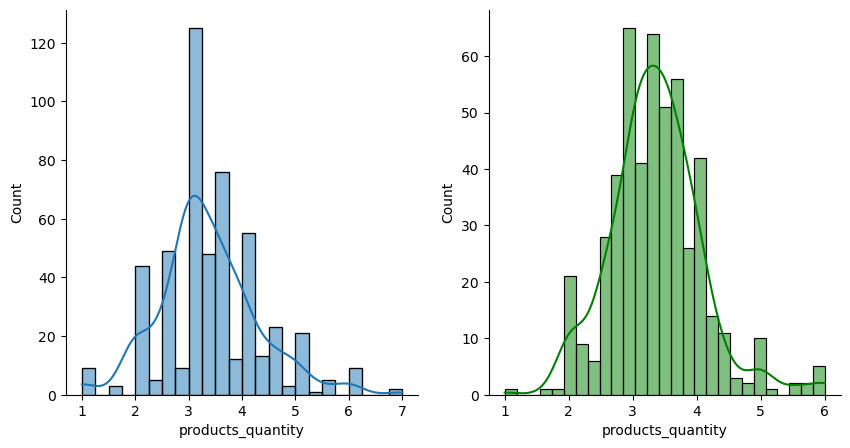

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
sns.histplot(control_group, x='products_quantity', kde=True)
plt.subplot(1, 2, 2)
sns.histplot(experimental_group, x='products_quantity', color='green', kde=True)
sns.despine()

In [ ]:
control_z_score = sc.zscore(control_group.products_quantity)
exp_z_score = sc.zscore(experimental_group.products_quantity)

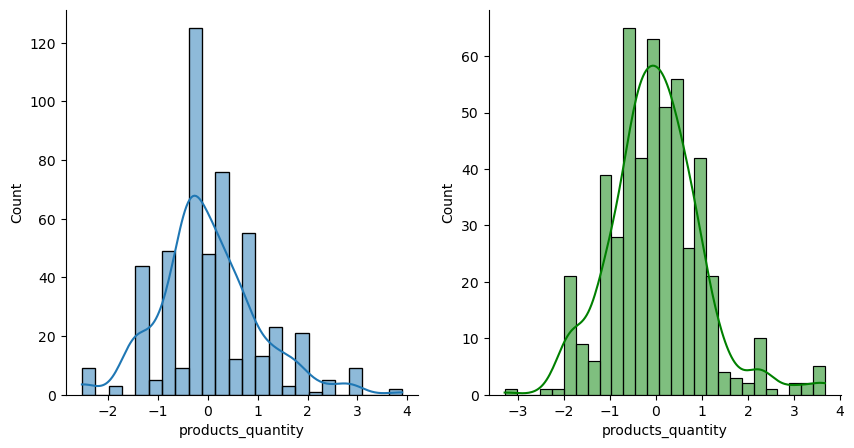

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
sns.histplot(control_z_score, kde=True)
plt.subplot(1, 2, 2)
sns.histplot(exp_z_score, color='green', kde=True)
sns.despine()

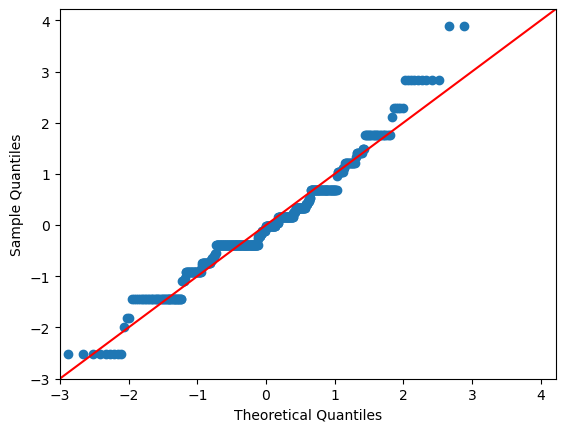

In [ ]:
fig_control = sm.qqplot(control_z_score, line ='45')
plt.show()

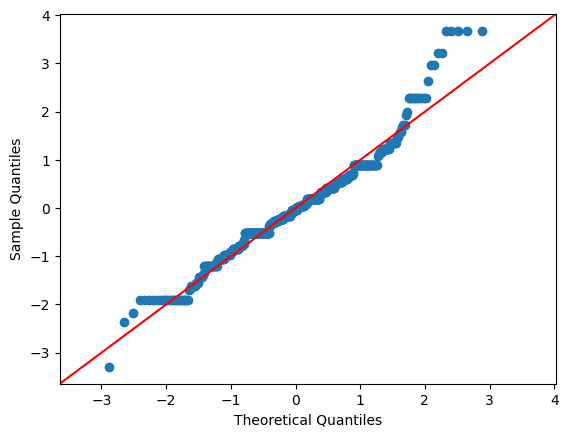

In [ ]:
fig_exp = sm.qqplot(exp_z_score, line ='45')
plt.show()

2. Несмотря на некоторые отклонения от предсказанных данных на графике QQ-plot, в целом в нашем случае оба распределения похожи на нормальное распределение, поэтому для проверки нулевой гипотезы о равенстве средних в двух группах я буду использовать t-test.

In [ ]:
sc.ttest_ind(experimental_group.products_quantity, control_group.products_quantity)

Ttest_indResult(statistic=0.1133553419271026, pvalue=0.9097713480198675)

In [ ]:
sc.mannwhitneyu(experimental_group.products_quantity, control_group.products_quantity)

MannwhitneyuResult(statistic=132173.0, pvalue=0.39850238989451314)

In [ ]:
def median_difference(data1, data2):
    return np.median(data1) - np.median(data2)

In [ ]:
boot_result = sc.bootstrap((experimental_group.products_quantity, control_group.products_quantity),
                            statistic=median_difference,
                            n_resamples=10000)

In [ ]:
median_diff = boot_result.bootstrap_distribution
conf_int = boot_result.confidence_interval
conf_int

ConfidenceInterval(low=-0.08333333333333348, high=0.1499999999999999)

<Axes: ylabel='Count'>

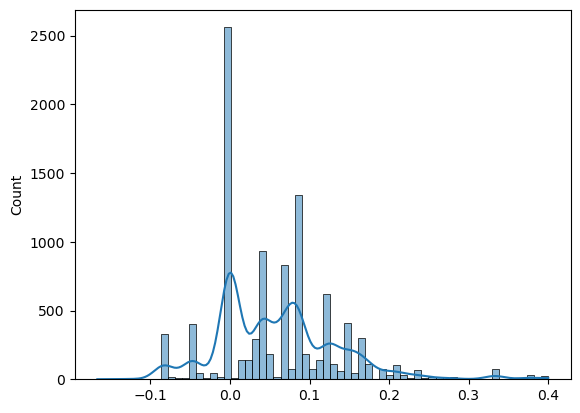

In [ ]:
sns.histplot(median_diff, kde=True)

<span style="color:SteelBlue">**Выводы:**</span>

По результатам t-test'а мы получили <span style="color:SteelBlue">p-value = 0.9</span>, что не позволяет отклонить нулевую гипотезу, в которой средние у двух наших групп равны, что в свою очередь означает, что умная система рекомендации товаров не дала значимой разницы.

В данной ситуации я применил t-test поскольку распределения данных близки к нормальным и стандартное отклонение в группах очень близко друг к другу. При такой ситуации t-test покажет наиболее точную оценку в разнице наших средних. Но при этом, дополнительно я решил сравнить средние тестами Манна-Уитни и бутстрапом, в которых также не получил статзначимых различий между средними в двух группах. В тесте Манна-Уитни я получил значение <span style="color:SteelBlue">p-value = 0.39</span>, что также не позволяет отклонить нулевую гипотезу, а с помощью бутстрапа я получил доверительный интервал равный <span style="color:SteelBlue">[-0.083, 0.149]</span> и в данный доверительный интервал входит значение 0, что означает, что разница между нашими группами не была обнаружена.

<span style="color:Tomato">**Рассуждения:**</span>

Поскольку если наша система позволяет "**эффективнее работать с приложением и лучше находить необходимые товары**", то проверить ээфективность работу можно через вторую метрику, которую стоит рассмотреть для данных двух групп, и эта метрика - <span style="color:Tomato">**средний чек пользователя**</span>

<span style="color:green">**1. Для этого необходимо создать колонку, в которой будет учтена сумма всех продуктов из колонки `product_ids`:**</span>

In [ ]:
id_price_dict = products.set_index('product_id')['price'].to_dict()

In [ ]:
orders['total_sum'] = orders['product_ids'].apply(lambda ids: sum(id_price_dict.get(int(id), 0) for id in ids))

In [ ]:
orders.head()

,order_id,creation_time,product_ids,total_sum
0,1255,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]",408.7
1,1256,2022-08-26 00:02:21.000000,"[56, 76, 39]",250.5
2,1257,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]",310.2
3,1258,2022-08-26 00:02:56.000000,"[74, 6]",85.0
4,1259,2022-08-26 00:03:37.000000,"[20, 45, 67, 26]",228.0


<span style="color:green">**2. Соединим таблицы `users_data` и `orders`, для получения наших групп:**</span>

In [ ]:
second_hypothesis_df = users_data.merge(orders, on='order_id')

In [ ]:
second_hypothesis_df.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids,total_sum
0,964,1255.0,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]",408.7
1,965,1256.0,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,"[56, 76, 39]",250.5
2,964,1257.0,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]",310.2
3,967,1259.0,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,2022-08-26 00:03:37.000000,"[20, 45, 67, 26]",228.0
4,968,1261.0,create_order,2022-08-26 00:05:35.000000,2022-08-26,0,2022-08-26 00:05:35.000000,"[30, 35, 69, 6]",430.7


In [ ]:
second_control_group = (second_hypothesis_df.query('group == 0')
                        .groupby('user_id')
                        .agg({'total_sum':'mean'})
                        .reset_index())

second_experimental_group = (second_hypothesis_df.query('group == 1')
                             .groupby('user_id')
                             .agg({'total_sum':'mean'})
                             .reset_index())

<span style="color:green">**3. И проверим различия в средних чеках пользователей на статзначимость у наших групп:**</span>

1. Построим графики распределения среднего количества товаров для двух наших групп, а также переведем значения в z-score, для проверки распределения на нормальность

<Axes: xlabel='total_sum', ylabel='Count'>

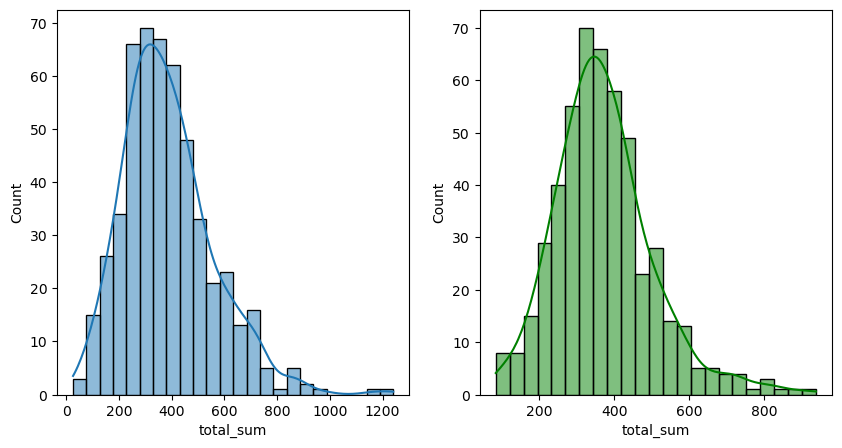

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
sns.histplot(second_control_group, x='total_sum', kde=True)
plt.subplot(1, 2, 2)
sns.histplot(second_experimental_group, x='total_sum', color='green', kde=True)

In [ ]:
second_control_z_score = sc.zscore(second_control_group.total_sum)
second_exp_z_score = sc.zscore(second_experimental_group.total_sum)

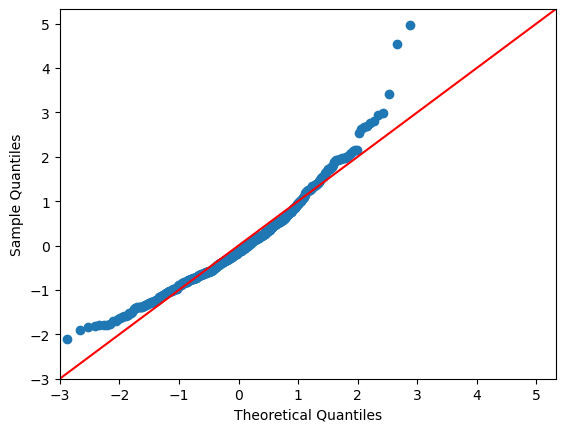

In [ ]:
fig_control = sm.qqplot(second_control_z_score, line ='45')
plt.show()

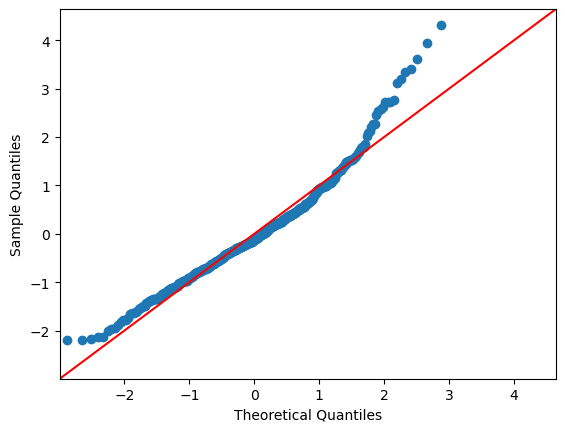

In [ ]:
fig_control = sm.qqplot(second_exp_z_score, line ='45')
plt.show()

2. Данные графики QQ-plot, в отличие от графиков количества покупок, показывают, что на хвостах нашего распределения значения завышены, поэтому в данном случае t-test будет работать менее корректно. И теперь для сравнения средних я буду использовать тест Манна-Уитни.

In [ ]:
sc.mannwhitneyu(second_control_group.total_sum, second_experimental_group.total_sum)

MannwhitneyuResult(statistic=130986.5, pvalue=0.5576189838851904)

In [ ]:
sc.ttest_ind(second_control_group.total_sum, second_experimental_group.total_sum)

Ttest_indResult(statistic=1.5407052777251002, pvalue=0.12370144988523067)

In [ ]:
boot_result = sc.bootstrap((second_control_group.total_sum, second_experimental_group.total_sum),
                            statistic=median_difference,
                            n_resamples=10000)

In [ ]:
median_diff = boot_result.bootstrap_distribution
conf_int = boot_result.confidence_interval
conf_int

ConfidenceInterval(low=-15.099392094702711, high=27.877500000000055)

<Axes: ylabel='Count'>

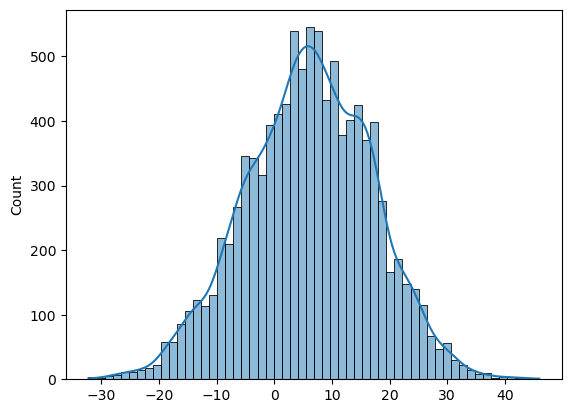

In [ ]:
sns.histplot(median_diff, kde=True)

<span style="color:SteelBlue">**Выводы:**</span>

По результатам теста Манна-Уитни мы получили <span style="color:SteelBlue">p-value = 0.56</span>, что не позволяет отклонить нулевую гипотезу, в которой сумма рангов у двух наших групп равны, что в свою очередь означает, что умная система рекомендации товаров не дала значимой разницы.

Также я дополнительно провел два теста как и при предыдущем рассмотрении двуз групп. В t-test я получил значение <span style="color:SteelBlue">p-value = 0.12</span>, что также не позволяет отклонить нулевую гипотезу, а с помощью бутстрапа я получил доверительный интервал равный <span style="color:SteelBlue">[-15.09, 27.88]</span> и в данный доверительный интервал входит значение 0, что означает, что разница между нашими группами не была обнаружена.